### Titulo

#### explicacion despues de aplicar los primeros dos pasos del metodo crisp, entender el modelo airbnb, navegr por pagna y ser usuario, se analizo la data disponible y se plantearon las siguientes preguntas

1. que influencia tiene la ubicacion en la ocupacion, es mejor indicador el codigo postal o regiones creados en base a clustering
2. que influencia tiene el host y el tipo de lugar
3. que influencia las reviews

en general encontrar las variables criticas para aumentar la ocupacion de una propiedad agrupadas en ubicación, host, place, y reviews

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Import train_test_split function
from sklearn.model_selection import train_test_split
#Import Random Forest Model classifier
from sklearn.ensemble import RandomForestClassifier
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
from sklearn.metrics import mean_squared_error
import seaborn as sns
pd.set_option('max_columns', None)
%matplotlib inline

open and consolidate data

In [2]:
# Open calendar and listings data
boston_calendar = pd.read_csv("boston_airbnb_data/calendar.csv")
boston_listings = pd.read_csv("boston_airbnb_data/listings.csv")

In [17]:
boston_listings

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",NaN,"The bus stop is 2 blocks away, and frequent. B...","You will have access to 2 bedrooms, a living r...",NaN,Clean up and treat the home the way you'd like...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,31303940,https://www.airbnb.com/users/show/31303940,Virginia,2015-04-15,"Boston, Massachusetts, United States",We are country and city connecting in our deck...,NaN,NaN,NaN,f,https://a2.muscache.com/im/pictures/5936fef0-b...,https://a2.muscache.com/im/pictures/5936fef0-b...,Roslindale,1,1,"['email', 'phone', 'facebook', 'reviews']",t,f,"Birch Street, Boston, MA 02131, United States",Roslindale,Roslindale,NaN,Boston,MA,02131,Boston,"Boston, MA",US,United States,42.282619,-71.133068,t,House,Entire home/apt,4,1.5,2.0,3.0,Real Bed,"{TV,""Wireless Internet"",Kitchen,""Free Parking ...",NaN,$250.00,NaN,NaN,NaN,$35.00,1,$0.00,2,1125,2 weeks ago,NaN,0,0,0,0,2016-09-06,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...","If you don't have a US cell phone, you can tex...",Plenty of safe street parking. Bus stops a few...,Apt has one more bedroom (which I use) and lar...,"If I am at home, I am likely working in my hom...",Pet friendly but please confirm with me if the...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,2572247,https://www.airbnb.com/users/show/2572247,Andrea,2012-06-07,"Boston, Massachusetts, United States",I live in Boston and I like to travel and have...,within an hour,100%,100%,f,https://a2.muscache.com/im/users/2572247/profi...,https://a2.muscache.com/im/users/2572247/profi...,Roslindale,1,1,"['email', 'phone', 'facebook', 'linkedin', 'am...",t,t,"Pinehurst Street, Boston, MA 02131, United Sta

In [20]:
boston_listings["last_scraped"].describe()

count           3585
unique             1
top       2016-09-07
freq            3585
Name: last_scraped, dtype: object

In [70]:
# Drop price column because we don't need it for our analysis
boston_calendar = boston_calendar.drop('price', axis=1)
# Get one column for each variable on for t(true) and one for f(false)
boston_calendar = pd.concat([boston_calendar.drop('available', axis=1), pd.get_dummies(boston_calendar['available'], prefix='available', prefix_sep='_')], axis=1)
# Group by each list id by adding the number of times each list_id is available and unavailable
boston_occupation = boston_calendar.groupby("listing_id").sum()
# Add a column with the occupancy percentage, which is the number of days occupied divided by the total number of days registered
boston_occupation["occupation_percentage"] = boston_occupation["available_f"]*100/(boston_occupation["available_f"]+boston_occupation["available_t"])
# Transform the output variable occupation_percentage that is continuous to categorical
# Define help function
def percentage_to_categorical(value):
    value = float(value)
    if value <= 100 and value >= 80:
        return 5
    elif value < 80 and value >= 60:
        return 4
    elif value < 60 and value >= 40:
        return 3
    elif value < 40 and value >= 20:
        return 2
    elif value < 20 and value >= 0:
        return 1
# Apply help function
boston_occupation["occupation_percentage"] = boston_occupation["occupation_percentage"].apply(percentage_to_categorical)
# Drop columns will no longer be used
boston_occupation = boston_occupation.drop(["available_f","available_t"], axis=1)

In [87]:
# Create a consolidate dataframe with all the airbnb data and the categoric
df = pd.merge(boston_listings, boston_occupation,left_on="id",right_on="listing_id", how="inner")

Nan analysis

In [72]:
# Create a dataframe with the column name and the percent of missing values per column
percent_missing = df.isnull().sum()*100/len(df)

df_nullrows_percent = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing}).reset_index(drop=True)

In [73]:
# Number of columns per range of percent missing values
df_nullrows_percent["percent_missing"].value_counts(bins=10, sort=False)

(-0.101, 10.0]    62
(10.0, 20.0]       7
(20.0, 30.0]      11
(30.0, 40.0]       5
(40.0, 50.0]       2
(50.0, 60.0]       1
(60.0, 70.0]       1
(70.0, 80.0]       2
(80.0, 90.0]       0
(90.0, 100.0]      5
Name: percent_missing, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12E103D0>]],
      dtype=object)

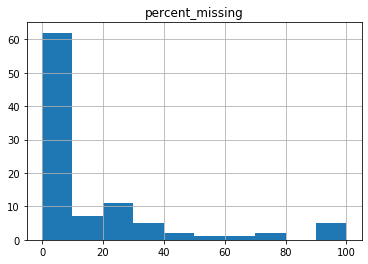

In [74]:
# Histogram of percent missing values
df_nullrows_percent.hist()

80 of 96 columns (83.3%) have less than 30% of their values miss and 62 of 96 columbs (64.58%) have less than 10% of their value miss. This makes it tempting to want to remove the columns with less than 10% of their values miss, but we do that we will miss all the columns related to reviews, so we are going to drop columns with mora than 30% of their values miss.

In [88]:
# Obtain the columns name that have less than 30% of their values miss
columns_lessthan30 = df_nullrows_percent[df_nullrows_percent["percent_missing"]<30]["column_name"].values.tolist()
# Filter the dataframe to have only those columns
df = df[columns_lessthan30]

en base a nuestro plantamiento incial de dividir en 3 dimesiones el analisis vamos a dividr nuestra data en cada una de estas dimensiones con sus correspondientes columnas para limpiarlas y observar la exactitud del modelo de forma individual.

dimensiones= host,property, reviews

#### Select host related columns

In [76]:
df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'thumbnail_url',
       'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed', 'city', 'state',
       'zipcode', 'market', 'smart_location', 'country_code', 'country',
       'latitude', 'longitude', 'is_location_exact', 'property_type',
       'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'bed_type', 'amenities', 'price', 'guests_included', 'extra_people',
       'minimum_nights', 'maximum_nights', 'calendar_up

In [151]:
host_columns = ["occupation_percentage","id","host_id","host_location","host_response_time","host_response_rate","host_acceptance_rate",
           "host_is_superhost","host_listings_count","host_total_listings_count","host_verifications",
          "host_has_profile_pic","host_identity_verified","city","calculated_host_listings_count"]

In [174]:
df_host = df[host_columns]

Host dimension analysis

-For columns host_response_rate and host_acceptance_rate we need to extract the % sign and transform the value to float.

-For column host_location we can simplify data by transofrming this column to host in city, en reality for the client the         loction of the host only mater if the host is in the same city so the variable is going to be create

-For columns host_verifications we need to check the unique posible values an create a column pero valdition and then assign 1 for those to have that verirication

The other column can be proces by get_dummies

In [175]:
#For columns host_response_rate and host_acceptance_rate we need to extract the % sign and transform the value to float.
df_host['host_response_rate'] = df_host['host_response_rate'].str.replace('%', '', regex=False).astype(float)
df_host['host_acceptance_rate'] = df_host['host_acceptance_rate'].str.replace('%', '', regex=False).astype(float)

c:\users\jordi\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\jordi\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [176]:
# Create column host_isin_city

def host_isin_city(host_location,city):
    try:
        clean_host_location = host_location.split(",")[0]
        if clean_host_location == "Boston":
            return True
        else:
            return False
    except AttributeError:
        return np.nan

df_host['host_in_city'] = df_host.apply(lambda x: host_isin_city(x.host_location, x.city), axis=1)
df_host = df_host.drop(["host_location","city"],axis=1)

# We can imput values for this column,so rows with nan value in this column is drop
df_hostdf = df_host.dropna(subset=['host_in_city'])

c:\users\jordi\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [177]:
all_verifications = []
all_clean_verifications = []
replacements = ['"',"'","[","]"]

for index, row in df_host.iterrows():
    verifications = row['host_verifications']
    for char in replacements:
        if char in verifications:
            verifications = verifications.replace(char,"")
            
    df_host.loc[index, 'host_verifications'] = verifications
    verifications = verifications.split(",")
    all_verifications += verifications
    
all_verifications = set(all_verifications)
for verification in all_verifications:
    if len(verification) != 0:
        clean_verification = verification.strip()
        all_clean_verifications.append(clean_verification)
        
# add one columns per clean_verification to the data frame
for verification in all_clean_verifications:
    df_host[verification] = 0
   
# add value 1 to correspond column if existe in the column host_verifications
for index, row in df_host.iterrows():
    verifications = row['host_verifications']
    for verification in verifications.split(","):
        verification = verification.strip()
        if verification in all_clean_verifications:
            df_host.loc[index, verification] = 1

# Drop host_verifications column because is no longer needed
df_host = df_host.drop(["host_verifications"], axis=1)

In [178]:
# por el momento para avanzar y ver si hace sentido el analisis, no se va a consolidar la información del host
# solo se van a eliminar los nan values y despues los duplicados, cada host y cada propuedad tienen diferente vaalor de
# ocupacion, por eso vamos a mantener la relacion host propiedad sin eliminar host duplicados

In [179]:
# eliminamos los valores con nan porque ahorita no nos interesan y sin pocos, excepcion response time se podria promediar por
# host pero por el momento los eliminamos para seguir avanzando y pulir adelante
df_host = df_host.dropna()

In [180]:
# Create dummi variables for the other categorical columns
cat_vars = df_host.select_dtypes(include=['object']).copy().columns
for var in  cat_vars:
    # for each cat add dummy var, drop original column
    df_host = pd.concat([df_host.drop(var, axis=1), pd.get_dummies(df_host[var],prefix=var, prefix_sep='_', drop_first=True)], axis=1)

In [181]:
df_ids = df_host[["id","host_id"]]
df_host = df_host.drop(["id","host_id"],axis=1)

#Split data into an X matrix and a response vector y
y = df_host['occupation_percentage']
x = df_host.drop('occupation_percentage', axis=1)

# Split dataset into training set and test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

In [203]:
#Create a Gaussian Classifier
rfc=RandomForestClassifier(n_estimators=500)

#Train the model using the training sets y_pred=clf.predict(X_test)
rfc.fit(x_train,y_train)

y_pred=rfc.predict(x_test)

In [204]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.5042918454935622


In [185]:
feature_importance = pd.Series(rfc.feature_importances_,index=list(x.columns)).sort_values(ascending=False)

No handles with labels found to put in legend.


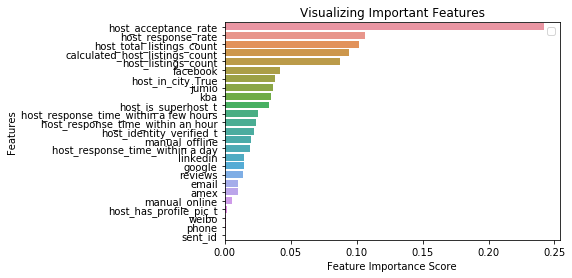

In [186]:
# Creating a bar plot
sns.barplot(x=feature_importance, y=feature_importance.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

In [202]:
y.value_counts()

1    1259
5     873
4     348
2     334
3     292
Name: occupation_percentage, dtype: int64

In [3]:
# Drop price column because we don't need it for our analysis
boston_calendar = boston_calendar.drop('price', axis=1)
# Get one column for each variable on for t(true) and one for f(false)
boston_calendar = pd.concat([boston_calendar.drop('available', axis=1), pd.get_dummies(boston_calendar['available'], prefix='available', prefix_sep='_')], axis=1)
# Group by each list id by adding the number of times each list_id is available and unavailable
boston_occupation = boston_calendar.groupby("listing_id").sum()
# Add a column with the occupancy percentage, which is the number of days occupied divided by the total number of days registered
boston_occupation["occupation_percentage"] = boston_occupation["available_f"]*100/(boston_occupation["available_f"]+boston_occupation["available_t"])
# Transform the output variable occupation_percentage that is continuous to categorical
# Define help function
# Drop columns will no longer be used
boston_occupation = boston_occupation.drop(["available_f","available_t"], axis=1)

In [11]:
# Create a consolidate dataframe with all the airbnb data and the categoric
df = pd.merge(boston_listings, boston_occupation,left_on="id",right_on="listing_id", how="inner")

In [5]:
df_1 = df[['host_acceptance_rate','occupation_percentage']]

In [6]:
df['host_acceptance_rate'] = df['host_acceptance_rate'].str.replace('%', '', regex=False).astype(float)

In [8]:
df = df.dropna()

In [9]:
df

,host_acceptance_rate,occupation_percentage
1,100.0,1.643836
2,88.0,12.602740
3,50.0,73.150685
4,100.0,8.493151
5,95.0,84.109589
...,...,...
3580,100.0,2.465753
3581,83.0,0.273973
3582,50.0,89.041096
3583,96.0,30.684932


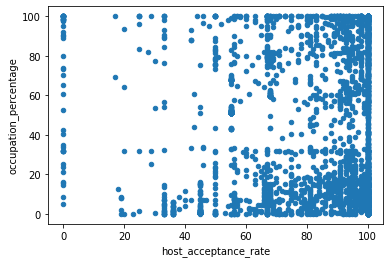

In [10]:
df.plot.scatter(x='host_acceptance_rate',y='occupation_percentage')

In [12]:
df_1 = df[['host_is_superhost','occupation_percentage']]

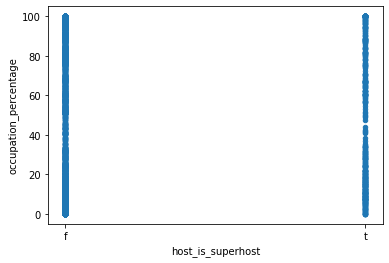

In [13]:
df_1.plot.scatter(x='host_is_superhost',y='occupation_percentage')

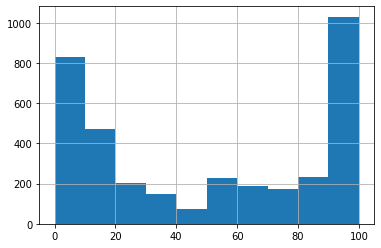

In [14]:
df["occupation_percentage"].hist()